In [15]:
import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
import geoplot as gplt
import seaborn as sns

import folium

from ipywidgets import interact, fixed

sns.set_style('white')
plt.rcParams.update({'font.size': 16})

# DOW Durations
- This dataset is used to see duration/distance/logduration by day of week, and also can be used to
- plot violin plot of workday vs non-workday changing datetime to months

In [2]:
df = pd.read_feather('./data/v2/dow_durations.feather').drop('index', axis=1)

C:\Users\akira\Anaconda3\lib\site-packages\pyarrow\pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In [ ]:
df['months'] = df['PUdatetime'].dt.month
df['hour'] = df['PUdatetime'].dt.hour
df.drop('PUdatetime',axis=1,inplace=True)

In [ ]:
df['Is_PeakHour'] = df['hour'].apply(lambda x: 1 if x in (8,9,10) or x in (4,5,6,7) else 0)

In [ ]:
fig, ax = fig, ax = plt.subplots(1, 1, figsize=(10,7))

sns.violinplot(x='months', y='log_duration', data=df, hue='Is_WorkDay', split=True, ax=ax, label='Day of Week')
ax.set_title("Duration of Trips (log minutes) by Month and Day of Week")
ax.set_ylabel("Trip Duration (log minutes)")
ax.set_xlabel("Month")

fig.savefig('./data/v2/plots/dow_violin.jpg')

plt.show()

In [ ]:
fig, ax = fig, ax = plt.subplots(1, 1, figsize=(10,7))

sns.violinplot(x='Day of Week', y='log_duration', data=df, hue='Is_PeakHour', split=True, ax=ax, label='Time of Day')
ax.set_title("Duration of Trips (log minutes) during Off-Peak and Peak Hours")
ax.set_ylabel("Trip Duration (log minutes)")
ax.set_xlabel("Day of Week")

fig.savefig('./data/v2/plots/rushhour_violin.jpg')

plt.show()

In [ ]:
df.groupby('Is_WorkDay')['trip_duration'].mean()

In [ ]:
df.groupby('Is_PeakHour')['trip_duration'].mean()

# By Months
- This dataset is an aggregation of ALL attributes by MONTH
- Includes TOTAL SUM / FREQ of trips made, how "snowy" or "rainy" the month was as well

In [ ]:
df = pd.read_csv('./data/v2/by_month.csv', index_col=0)

In [ ]:
df

In [ ]:
fig, ax = fig, ax = plt.subplots(1, 1, figsize=(10,7))

plt.grid(False)

sns.barplot(x='month',y='trip_duration', data=df, ax=ax, label='Trip Duration')
ax.set_title("Duration of Trips (minutes) by Month")
ax.set_ylabel("Trip Duration (minutes)")
ax.set_xlabel("Month")
ax.set_ylim(12.5, 20)

plt.savefig("./data/v2/plots/duration_trips_month.jpg")

In [ ]:
fig, ax = fig, ax = plt.subplots(1, 1, figsize=(10,7))

plt.grid(False)

sns.barplot(x='month',y='count', data=df, ax=ax, label='Trip Duration')
ax.set_title("Number of Trips by Month")
ax.set_ylabel("Number of Trips (x10⁷)")
ax.set_xlabel("Month")
ax.set_ylim(7500000, 10000000)

plt.savefig("./data/v2/plots/number_of_trips_month.jpg")

In [ ]:
df['total'] = df['trip_duration'] * df['count']

fig, ax = fig, ax = plt.subplots(1, 1, figsize=(10,7))

plt.grid(False)

sns.barplot(x='month',y='total', data=df, ax=ax, label='Trip Duration')
ax.set_title("Grand Total of Minutes Driven by Month")
ax.set_ylabel("Grand Total of Trip Duration (minutes)")
ax.set_xlabel("Month")
ax.set_ylim(125000000, 170000000)

plt.savefig("./data/v2/plots/grand_total_month.jpg")

In [ ]:
fig, ax = fig, ax = plt.subplots(1, 1, figsize=(14,7))

plt.grid(False)

df[['month','heavy_snow','snow','heavy_rain','rain','count']].plot.bar(ax=ax, x='month')
ax.set_title("Weather Impacts on Trip Frequency by Month")
ax.set_ylabel("Total Count")
ax.set_xlabel("Month")
ax.set_xlim(-0.5,12)

plt.setp(ax.xaxis.get_majorticklabels(), rotation=0)
plt.legend(loc=(1.025,0.775))

plt.savefig("./data/v2/plots/number_of_trips_month.jpg")

In [ ]:
df.corr()

In [ ]:
plt.figure(figsize=(10,7))
sns.heatmap(df.corr())

plt.savefig('./data/v2/plots/weather_corrHeatmap.jpg')

plt.show()

In [ ]:
df

# By Zone
- This dataset is an aggregation of ALL attributes by ZONES
- Useful for plotting choropleth for duration/logduration/distance/fare/tip/freq
- **Need to merge with shapefiles**

In [5]:
zones = pd.read_csv('./data/taxi+_zone_lookup.csv')

sf = gpd.read_file("./data/taxi_zones/taxi_zones.shp")
# Drop these columns since they are preserved in the zone_lookup.csv 
sf.drop(['OBJECTID','Shape_Leng','Shape_Area','zone','borough'],axis=1,inplace=True)
# Convert to long/lat 
sf['geometry'] = sf['geometry'].to_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")

In [6]:
df1 = pd.read_csv('./data/v2/zone_agg.csv', index_col=0)
df1 = gpd.GeoDataFrame(pd.merge(df1, sf, left_on='PULocationID', right_on='LocationID')).drop('PULocationID',axis=1)

In [7]:
zones.head()

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone


# Folium Plots

In [ ]:
dfzone = pd.merge(df1, zones, on='LocationID')
geo = gpd.GeoDataFrame(dfzone[['LocationID','geometry']]).to_json()

In [ ]:
nyc_map = folium.Map(location=[40.66, -73.94], tiles="Stamen Terrain", zoom_start=10)

folium.Choropleth(
    geo_data=geo,
    name='choropleth',
    fill_color='blue',
    fill_opacity=0.15,
    line_opacity=0.75
).add_to(nyc_map)

nyc_map.save('./data/v2/plots/nyc_map_interactive.html')

In [ ]:
ld_m = folium.Map(location=[40.66, -73.94], tiles="Stamen Terrain", zoom_start=11)

folium.Choropleth(
    geo_data=geo,
    name='choropleth',
    data=dfzone,
    columns=['LocationID', 'log_duration'],
    key_on='properties.LocationID',
    fill_color='OrRd',
    fill_opacity=0.9,
    line_opacity=0.5,
    legend_name='log(Trip Duration)'
).add_to(ld_m)

ld_m.save('./data/v2/plots/choropleth_logduration_interactive.html')

In [ ]:
geo_t15 = gpd.GeoDataFrame(top_15[['LocationID','geometry']]).to_json()
t15_m = folium.Map(location=[40.66, -73.94], tiles="Stamen Terrain", zoom_start=11)

folium.Choropleth(
    geo_data=geo_t15,
    name='choropleth',
    data=top_15,
    columns=['LocationID', 'log_duration'],
    key_on='properties.LocationID',
    fill_color='OrRd',
    fill_opacity=0.9,
    line_opacity=0.5,
    legend_name='log(Trip Duration)'
).add_to(t15_m)

t15_m.save('./data/v2/plots/choropleth_top15_duration_interactive.html')

In [8]:
weather_df = pd.merge(pd.read_csv('./data/v2/by_zone.csv', index_col=0), sf, left_on='PULocationID', right_on='LocationID').drop('PULocationID',axis=1)

In [9]:
weather_df.head()

,month,trip_duration,trip_distance,tmpc,heavy_snow,snow,heavy_rain,rain,count,LocationID,geometry
0,1,15.683333,9.143167,14.154444,14.0,14.0,20.0,23.0,60,1,"POLYGON ((-74.18445299999996 40.6949959999999,..."
1,2,16.758621,7.280517,22.265000,0.0,0.0,27.0,28.0,58,1,"POLYGON ((-74.18445299999996 40.6949959999999,..."
2,3,26.694915,11.049831,12.412000,23.0,23.0,23.0,27.0,59,1,"POLYGON ((-74.18445299999996 40.6949959999999,..."
3,4,43.738462,8.965692,21.020000,0.0,0.0,44.0,48.0,65,1,"POLYGON ((-74.18445299999996 40.6949959999999,..."
4,5,19.250000,9.426842,28.890000,0.0,0.0,50.0,51.0,76,1,"POLYGON ((-74.18445299999996 40.6949959999999,..."


In [ ]:
geo_event = gpd.GeoDataFrame(weather_df.loc[weather_df.month == 4][['LocationID','geometry']]).to_json()
event_m = folium.Map(location=[40.66, -73.94], tiles="Stamen Terrain", zoom_start=11)

folium.Choropleth(
    geo_data=geo_event,
    name='choropleth',
    data=weather_df,
    columns=['LocationID', 'count'],
    key_on='properties.LocationID',
    fill_color='OrRd',
    fill_opacity=0.9,
    line_opacity=0.5,
    legend_name='Number of Trips made'
).add_to(event_m)

event_m.save('./data/v2/plots/choropleth_events_may.html')

In [ ]:
geo_event = gpd.GeoDataFrame(weather_df.loc[weather_df.month == 11][['LocationID','geometry']]).to_json()
event_m = folium.Map(location=[40.66, -73.94], tiles="Stamen Terrain", zoom_start=11)

folium.Choropleth(
    geo_data=geo_event,
    name='choropleth',
    data=weather_df,
    columns=['LocationID', 'count'],
    key_on='properties.LocationID',
    fill_color='OrRd',
    fill_opacity=0.9,
    line_opacity=0.5,
    legend_name='Fare Amount + Tips per Trip'
).add_to(event_m)

event_m.save('./data/v2/plots/choropleth_events_sept.html')

In [ ]:
df1['money_per_trip'] = df1['fare_amount'] + df1['tip_amount']
df1['total_money'] = (df1['fare_amount'] + df1['tip_amount']) * df1['freq']

In [ ]:
df1.head()

In [ ]:
profits = pd.merge(df1[['LocationID','money_per_trip','total_money','freq','geometry']], zones, on='LocationID')
best_trips = profits.sort_values('money_per_trip', ascending=False)[['LocationID','Zone','money_per_trip','freq','geometry']]
most_money = profits.sort_values('total_money', ascending=False)[['LocationID','Zone','total_money','freq','geometry']]

In [ ]:
best_trips.head()

In [ ]:
most_money.head()

In [ ]:
geo_mm = gpd.GeoDataFrame(most_money[['LocationID','geometry']]).to_json()
most_money['log_tm'] = np.log(most_money['total_money'])
mm_m = folium.Map(location=[40.66, -73.94], tiles="Stamen Terrain", zoom_start=11)

folium.Choropleth(
    geo_data=geo_mm,
    name='choropleth',
    data=most_money,
    columns=['LocationID', 'total_money'],
    key_on='properties.LocationID',
    fill_color='Purples',
    fill_opacity=0.9,
    line_opacity=0.5,
    legend_name='Grand Total of Money Made'
).add_to(mm_m)

mm_m.save('./data/v2/plots/choropleth_most_money.html')

In [ ]:
geo_ld = gpd.GeoDataFrame(best_trips[['LocationID','geometry']]).to_json()
ld_m = folium.Map(location=[40.66, -73.94], tiles="Stamen Terrain", zoom_start=11)

folium.Choropleth(
    geo_data=geo_ld,
    name='choropleth',
    data=best_trips,
    columns=['LocationID', 'money_per_trip'],
    key_on='properties.LocationID',
    fill_color='Purples',
    fill_opacity=0.9,
    line_opacity=0.5,
    legend_name='Profit per Trip'
).add_to(ld_m)

ld_m.save('./data/v2/plots/choropleth_best_trips.html')

In [ ]:
df1.head()

In [ ]:
df1['expected_rate_time'] = np.log((df1['money_per_trip'] / df1['trip_duration']) * (df1['freq'] / df1['freq'].sum()))
df1['expected_rate_dist'] = np.log((df1['money_per_trip'] / df1['trip_distance']) * (df1['freq'] / df1['freq'].sum()))

In [ ]:
test = gpd.GeoDataFrame(df1[['LocationID','geometry']]).to_json()
test_m = folium.Map(location=[40.66, -73.94], tiles="Stamen Terrain", zoom_start=11)

folium.Choropleth(
    geo_data=test,
    name='choropleth',
    data=df1,
    columns=['LocationID', 'expected_rate_time'],
    key_on='properties.LocationID',
    fill_color='YlGnBu',
    fill_opacity=0.9,
    line_opacity=0.5,
    legend_name='log(Expected Money per Minute x Proportion of Trips)'
).add_to(test_m)

test_m.save('./data/v2/plots/min_prop.html')

In [ ]:
test = gpd.GeoDataFrame(df1[['LocationID','geometry']]).to_json()
test_m = folium.Map(location=[40.7, -73.94], tiles="Stamen Terrain", zoom_start=11)

folium.Choropleth(
    geo_data=test,
    name='choropleth',
    data=df1,
    columns=['LocationID', 'expected_rate_dist'],
    key_on='properties.LocationID',
    fill_color='YlGnBu',
    fill_opacity=0.9,
    line_opacity=0.5,
    legend_name='log(Expected Money per Mile x Proportion of Trips)'
).add_to(test_m)

test_m.save('./data/v2/plots/dist_prop.html')

In [12]:
# compare snow 1
weather_df['log_count'] = np.log(weather_df['count'])

SNOW = weather_df.loc[weather_df['heavy_snow'] > 0]
SNOW = SNOW.loc[SNOW['count'] > 60]

snow = gpd.GeoDataFrame(SNOW[['LocationID','geometry']]).to_json()
snow_m = folium.Map(location=[40.7, -73.94], tiles="Stamen Terrain", zoom_start=11)

folium.Choropleth(
    geo_data=snow,
    name='choropleth',
    data=SNOW,
    columns=['LocationID', 'log_count'],
    key_on='properties.LocationID',
    fill_color='RdPu',
    fill_opacity=0.9,
    line_opacity=0.5,
    legend_name='log(Number of Trips) in Snowy Conditions'
).add_to(snow_m)

snow_m.save(f'./data/v2/plots/snow/allsnow.html')

In [13]:
# compare normal 2
NORMAL = weather_df.loc[weather_df['heavy_snow'] == 0]

norm = gpd.GeoDataFrame(NORMAL[['LocationID','geometry']]).to_json()
norm_m = folium.Map(location=[40.7, -73.94], tiles="Stamen Terrain", zoom_start=11)

folium.Choropleth(
    geo_data=norm,
    name='choropleth',
    data=NORMAL,
    columns=['LocationID', 'log_count'],
    key_on='properties.LocationID',
    fill_color='RdPu',
    fill_opacity=0.9,
    line_opacity=0.5,
    legend_name='log(Number of Trips) in Normal Weather Conditions'
).add_to(norm_m)

norm_m.save(f'./data/v2/plots/snow/allnormal.html')

In [17]:
weather_df['is_snow'] = weather_df['heavy_snow'].apply(lambda x: 1 if x > 0 else 0)
weather_df['log_duration'] = np.log(weather_df['trip_duration'])

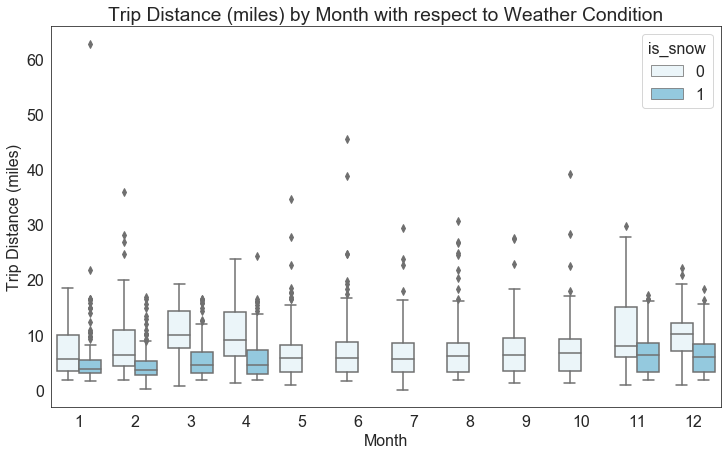

In [18]:
fig, ax = fig, ax = plt.subplots(1, 1, figsize=(12,7))

sns.boxplot(x='month', y='trip_distance', hue='is_snow', data=weather_df, ax=ax, color='skyblue')

ax.set_title("Trip Distance (miles) by Month with respect to Weather Condition")
ax.set_ylabel("Trip Distance (miles)")
ax.set_xlabel("Month")

fig.savefig('./data/v2/plots/snow/distance_snow.jpg')

plt.show()

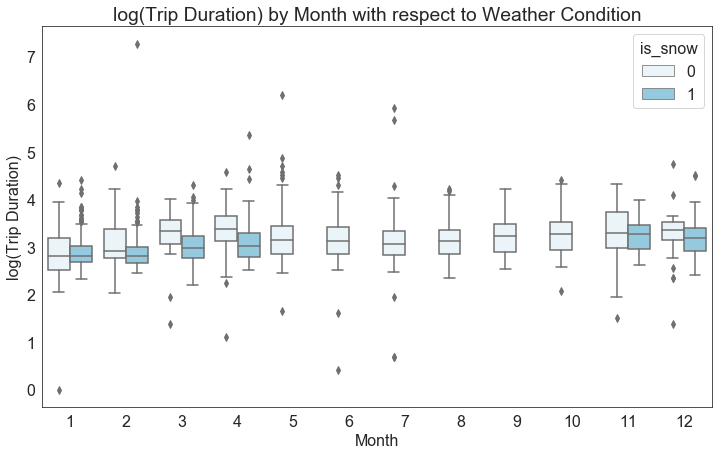

In [19]:
fig, ax = fig, ax = plt.subplots(1, 1, figsize=(12,7))

sns.boxplot(x='month', y='log_duration', hue='is_snow', data=weather_df, ax=ax, color='skyblue')

ax.set_title("log(Trip Duration) by Month with respect to Weather Condition")
ax.set_ylabel("log(Trip Duration)")
ax.set_xlabel("Month")

fig.savefig('./data/v2/plots/snow/duration_snow.jpg')

plt.show()

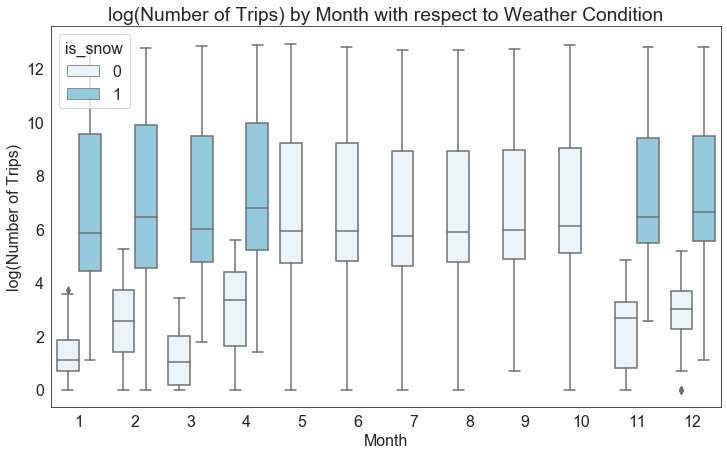

In [20]:
fig, ax = fig, ax = plt.subplots(1, 1, figsize=(12,7))

sns.boxplot(x='month', y='log_count', hue='is_snow', data=weather_df, ax=ax, color='skyblue')

ax.set_title("log(Number of Trips) by Month with respect to Weather Condition")
ax.set_ylabel("log(Number of Trips)")
ax.set_xlabel("Month")

fig.savefig('./data/v2/plots/snow/count_snow.jpg')

plt.show()